In [1]:
using Gen
using PyPlot

Set the seed so the notebook results are reproducible:

In [2]:
srand(1);

# 1. Probabilistic programs in Gen

We begin by learning to use Gen to write generative probabilistic models.
In Gen, probabilistic models are represented as *probabilistic programs*. 
The random choices used inside a probabilistic program represent the random variables in the generative probabilistic model.
An assignment of values for some or all of the random choices in a program is called a *trace* of the program.

### Writing a probabilistic program
Let's begin by writing a typical Bayesian network model as a Gen probabilistic program.

A probabilistic program in Gen is simply a Julia function whose first argument is `T::Trace`, and in which random choices have been tagged with names using the `~` syntax:

In [3]:
function sprinkler_model(T::Trace)
     cloudy = flip(0.5) ~ "cloudy"
     sprinkler = flip(cloudy ? 0.1 : 0.5) ~ "sprinkler"
     rain = flip(cloudy ? 0.8 : 0.2) ~ "rain"
     wetgrass = flip(
         if sprinkler
             rain ? 0.99 : 0.9
         else
             rain ? 0.9 : 0.01
         end) ~ "wetgrass"
end

sprinkler_model (generic function with 1 method)

### Tracing a probabilistic program
We run a probabilistic program by passing in a `Trace` object. When the program is run, it records the value of each named random choice into trace.

In [4]:
sprinkler_trace = Trace()
sprinkler_model(sprinkler_trace)

true

We can now inspect the trace:

In [5]:
cloudy = sprinkler_trace["cloudy"]
sprinkler = sprinkler_trace["sprinkler"]
rain = sprinkler_trace["rain"]
wetgrass = sprinkler_trace["wetgrass"]
println("cloudy=$cloudy") # NOTE Julia's string interpolation syntax
println("sprinkler=$sprinkler")
println("rain=$rain")
println("wetgrass=$wetgrass")

cloudy=true
sprinkler=false
rain=true
wetgrass=true


### Problem 1.1
List all possible traces for the `sprinker_model` program above, and the probability for each trace. Check that they sum to 1.0. Feel free to generate
the list programatically.

In [6]:
# ANSWER HERE

### Problem 1.2
Give a directed acyclic graph (DAG) expressing the conditional independencies between random choices in the above `sprinkler_model` program (i.e. the Bayesian network for the probabilistic model). Specify the DAG by its vertices and edges.

In [7]:
# ANSWER HERE

### A program with an unbounded number of random choices
Here is a program with an unbounded number of random choices:

**Note:** Probabilistic programs are regular Julia functions, and can can be parameterized by adding function parameters. Here, we parameterize the recursion_program by the probability of each flip resulting in heads:

In [8]:
function foo(T::Trace, n::Int, prob_heads::Float64)
    if (flip(prob_heads) ~ "flip_$n")
        foo(T, n + 1, prob_heads)
    else
        n
    end
end

function recursion_program(T::Trace, prob_heads::Float64)
    return foo(T,0, prob_heads)
end

return_values = []
for i=1:20
    push!(return_values, recursion_program(Trace(), 0.1))
end
println("return values: $return_values")

return values: Any[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0]


Note that in the program above we used Julia's string interpolation syntax to form the random choice names. For example:

In [9]:
n = 10
println("flip_$n")
println("flip_$(n * 2)")

flip_10
flip_20


These strings are evaluated during program execution in the same environment as the rest of the code in the probabilistic program.

Note that probabilitsic programs can use sub-routines, and these sub-routines can have traced random choices, along as they also have the T::Trace as their first argument

In [10]:
# One traced execution of recursion_program
println("\nFirst execution")
recursion_trace = Trace()
return_value = recursion_program(recursion_trace, 0.5)
for key in keys(recursion_trace)
    println("$key=$(recursion_trace[key])")
end
println("return-value=$return_value")

# Another traced execution
println("\nSecond execution")
recursion_trace = Trace() 
return_value = recursion_program(recursion_trace, 0.5)
for key in keys(recursion_trace)
    println("$key=$(recursion_trace[key])")
end
println("return-value=$return_value")



First execution
flip_1=false
flip_0=true
return-value=1

Second execution
flip_1=false
flip_0=true
return-value=1


Note that the number of random choices that were sampled is different between the two executions. Unlike Bayesian networks, probabilistic programs can represent models in which (1) the set of which random choices are sampled is itself a random object, and (2) the set of random choices is potentially countably infinite.

We next perform 20 independent traced executions of the program, and list the value of the return value in each.

In [11]:
return_values = []
for i=1:20
    push!(return_values, recursion_program(Trace(), 0.5))
end
println("return values: $return_values")

return values: Any[3,1,3,1,0,2,0,0,1,2,0,1,2,0,0,0,0,1,3,1]


Unsurprisingly, changing that parameter has a pretty drastic effect on the distribution of return values.

## Problem 1.3

Recall that a trace is the set of random choices and their values.

(a) List the set of possible traces for the recursion_example program above, the probability of each possible trace, and the value of output for each trace. Do the probabilities sum to 1?

(b) Describe the marginal distribution of output.

(c) Can you draw a Bayesian network corresponding to `recursion_program`?

In [12]:
# ANSWER HERE

Consider the probabilistic program `shared_or_separate` below. Note that we have parameterized this program by a `num_obs` parameter. Also note that we do not name all of the random choices. In Gen, not all random choices need to be named.

In [13]:
function shared_or_separate(T::Trace, num_obs::Int)
    mean_shared = normal(0., 10.)
    mean_1 = normal(0., 10.)
    mean_2 = normal(0., 10.)
    variance = Gen.gamma(1., 1.)
    shared = flip(0.2) ~ "shared"
    outputs = []
    for i=1:num_obs
        if i < num_obs / 2
            # cohort 1 (first half of data points)
            if shared
                mu = mean_shared
            else
                mu = mean_1
            end
        else
            # cohort 2 (second half of data points)
            if shared
                mu = mean_shared
            else
                mu = mean_2
            end
        end
        push!(outputs, normal(mu, sqrt(variance)) ~ "output-$i")
    end
    return outputs
end

shared_or_separate (generic function with 1 method)

Below, we run this program many times, and plot the histogram of the outputs for each run. We use PyPlot which is a Julia package that wraps Python's matplotlib module.

In [14]:
all_outputs = []
for replicate=1:24
    outputs = shared_or_separate(Trace(), 50)
    push!(all_outputs, outputs)
end

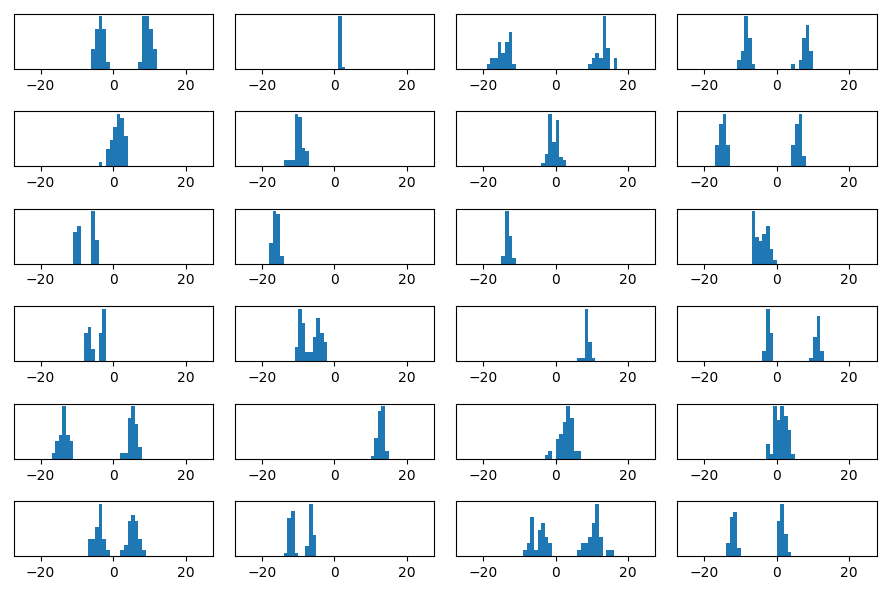

In [15]:
plt[:figure](figsize=(9, 6))
for (i, outputs) in enumerate(all_outputs)
    plt[:subplot](6, 4, i)
    plt[:hist](outputs, bins=50, range=(-25, 25))
    ax = plt[:gca]()
    plt[:gca]()[:get_yaxis]()[:set_visible](false)
end
plt[:tight_layout]()

## Problem 1.4

(a) Describe what the `shared_or_separate` program above is doing, and a possible use of this program as a probabilistic model of data.

(b) Run a new experiment where you extract the value of `shared` for each run of the program, and and use the value of `shared` to improve the histogram, by coloring the runs for which `shared=true` differently fromthe renderings for which `shared=false`.

In [16]:
# ANSWER HERE

The probabilistic program below defines a Bayesian linear regression model.

In [17]:
function linear_regression(T::Trace, xs::Array{Float64,1})
    slope = normal(0., 2.) ~ "slope"
    intercept = normal(0., 2.) ~ "intercept"
    variance = 1.0
    line = (x::Float64) -> intercept + slope * x
    ys = map(
            (i) -> normal(line(xs[i]), variance) ~ "y$i", 
            1:length(xs))
end

linear_regression (generic function with 1 method)

In [18]:
trace = Trace()
linear_regression(trace, [-3., -2., -1., 0., 1., 2., 3.])
for key in keys(trace)
    println("$key=$(trace[key])")
end

slope=-2.0390799361553578
intercept=-1.7018867818836094
y3=1.2892125550152211
y1=4.68860039694908
y4=-3.6819348877097644
y2=2.75177830836036
y7=-8.133435447612007
y6=-5.827448214584529
y5=-3.6558162893797035


Let's visualize the traces for many repeated executions. We will visualize the `slope` and `intercept` by plotting the corresponding line, and we will scatterplot the x, y pairs. We visualize a trace by writing a *trace rendering* function, that takes a trace and any other input parameters as arguments and draws a plot onto the current axis.

In [19]:
traces = []
xs = collect(linspace(-5.0, 5.0, 20))
for replicate=1:36
    trace = Trace()
    linear_regression(trace, xs)
    push!(traces, trace)
end

In [20]:
function render_linear_regression_trace(trace::Trace,
                                         xs::Array{Float64,1},
                                         ax, xlim, ylim)
    slope = trace["slope"]
    intercept = trace["intercept"]
    ys = map((i) -> trace["y$i"], 1:length(xs))
    ax[:scatter](xs, ys, lw=0, s=50)
    ax[:plot](xlim, slope * xlim + intercept, color="green", lw=4)
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

render_linear_regression_trace (generic function with 1 method)

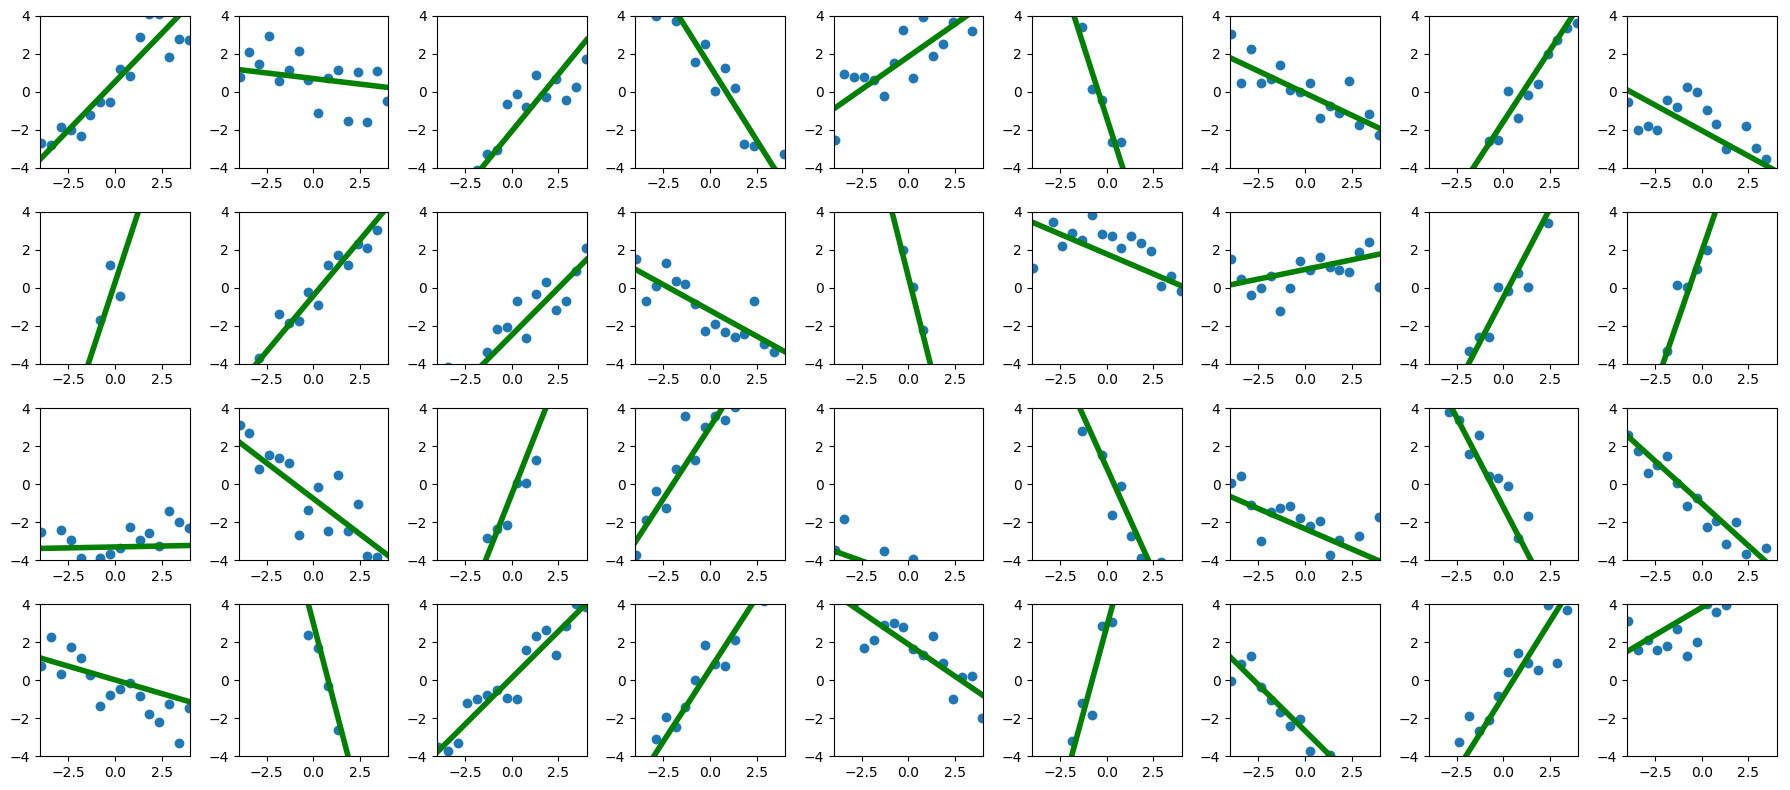

In [21]:
plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_linear_regression_trace(trace, xs, ax, xlim, ylim)
end
plt[:tight_layout]()

## Problem 1.5

Run a number of traced executions of `linear_regression` with modified inputs, render the outputs, and describe how your change affects the prior distribution on traces. For example, what happens if you increase the variance of the prior on the slope?

In [22]:
# ANSWER HERE

The program below shows an extended version of the linear regression model, where each data point may be an outlier or an inlier.

In [23]:
function linear_regression_outliers(T::Trace, xs::Array{Float64,1})
    inlier_noise = gamma(1., 1.) ~ "inlier_noise"
    outlier_noise = 10.0
    prob_outlier = 0.1
    slope = normal(0.0, 2.0) ~ "slope"
    intercept = normal(0.0, 2.0) ~ "intercept"
    ys = Array{Float64, 1}(length(xs))
    for i=1:length(xs)
        y_mean = intercept + slope * xs[i]
        noise = (flip(prob_outlier) ~ "o$i") ? outlier_noise : inlier_noise 
        ys[i] = normal(y_mean, noise) ~ "y$i"
    end
end


linear_regression_outliers (generic function with 1 method)

We write a new trace rendering for it that shows the outlier data points in red, and shows the value of `inlier_noise` using error bars above and below the line.

In [24]:
function render_linear_regression_outliers_trace(trace::Trace,
                                                 xs::Array{Float64,1},
                                                 ax, xlim, ylim)
    slope = trace["slope"]
    intercept = trace["intercept"]
    ys = map((i) -> trace["y$i"], 1:length(xs))
    outlier_statuses = map((i) -> trace["o$i"], 1:length(xs))
    inlier_noise = trace["inlier_noise"]
    colors = map((i) -> outlier_statuses[i] ? "red" : "blue", 1:length(xs))
    ax[:scatter](xs, ys, lw=0, s=50, c=colors)
    line = intercept + slope * xlim
    ax[:plot](xlim, slope * xlim + intercept, color="green", lw=4)
    plt[:fill_between](xlim, line - inlier_noise, line, color="black", alpha=0.3)
    plt[:fill_between](xlim, line, line + inlier_noise, color="black", alpha=0.3)
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

render_linear_regression_outliers_trace (generic function with 1 method)

In [25]:
traces = []
xs = collect(linspace(-5.0, 5.0, 20))
for replicate=1:36
    trace = Trace()
    linear_regression_outliers(trace, xs)
    push!(traces, trace)
end

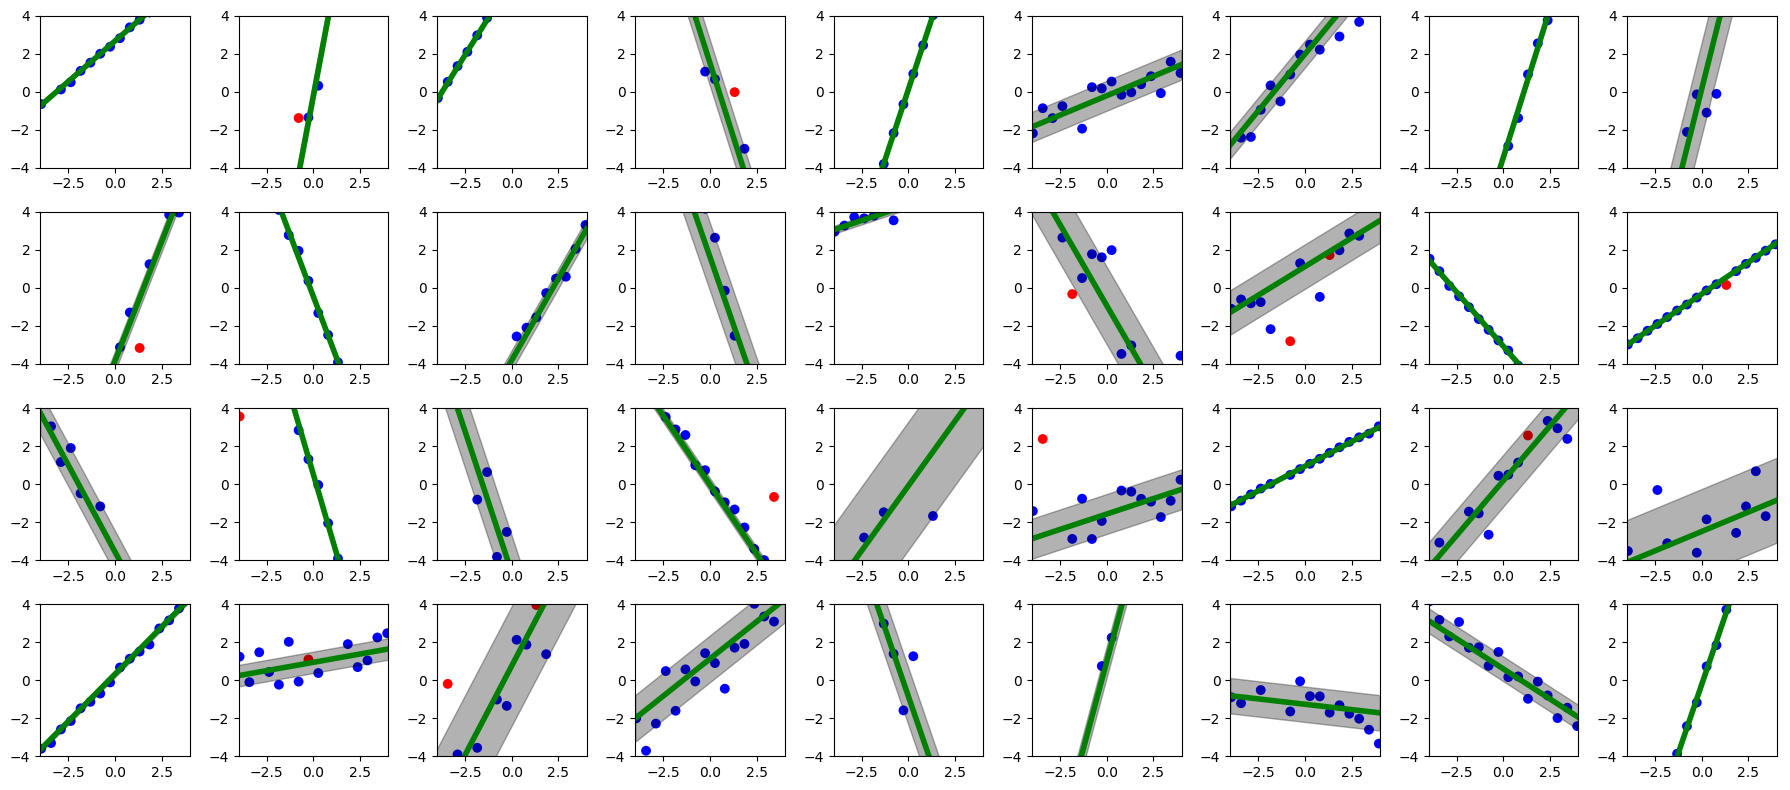

In [26]:
plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_linear_regression_outliers_trace(trace, xs, ax, xlim, ylim)
end
plt[:tight_layout]()

Now you understand how to write probabilistic models in Gen, and how to understand their behavior by visualizing simulations from the models. Next, we will show how to perform approximate probabilistic inference in Gen.

# 2. Approximate probabilistic inference
Probabilistic inference in a Gen model involves finding values for latent variables that are compatible with a set of *constraints* placed on the trace of the program. A *constraint* is a value for a random choice made within the program. We express constraints in Gen by setting values in the trace that we pass into a probabilistic program.

For example, the program below has one latent random choice (`mu`) and three observed random choices (`x1`, `x2`, and `x3`).

In [27]:
function simple_model(T::Trace)
    mu = normal(0.0, 10.0) ~ "mu"
    x1 = normal(mu, 1.0) ~ "x1"
    x2 = normal(mu, 1.0) ~ "x2"
    x3 = normal(mu, 1.0) ~ "x3"
end

simple_model (generic function with 1 method)

 We wish to infer likely values of `mu` given specific observed values for `x1`, `x2`, and `x3`. First, we create an empty trace, and add constraints to it by setting `x1` through `x3` to their observed values:

In [28]:
trace = Trace()
trace["x1"] = 3.4
trace["x2"] = 4.6
trace["x3"] = 4.2;

The maximum likelihood estimate for `mu` is the mean of the data, and we expect the Bayesian posterior over `mu` should be concentrated near that point, shifted downwards somewhat due to the prior. For this dataset, we expect reasonable a inference algorithm to give values for `mu` lying in the range 3.5-4.5.

A key feature of Gen (and most other probabilistic programming languages) is that, given a trace and a program, it automatically computes a score that indicates how probable the trace is. Let's compute the score for a reasonable value of `mu` and an unreasonable value:

In [29]:
trace = Trace()
trace["x1"] = 3.4
trace["x2"] = 4.6
trace["x3"] = 4.2;
trace["mu"] = 4.0 # reasonable value
simple_model(trace);
println("score for reasonable mu $(trace.log_weight)")

trace = Trace()
trace["x1"] = 3.4
trace["x2"] = 4.6
trace["x3"] = 4.2;
trace["mu"] = -10.0 # unreasonable value
simple_model(trace)
println("score for unreasonable mu $(trace.log_weight)")

score for reasonable mu -6.438339225812736
score for unreasonable mu -303.6583392258127


We can also have the program propose its own values for `mu` from the prior, and return the score for the proposed value:

In [30]:
for i=1:3
    trace = Trace()
    trace["x1"] = 3.4
    trace["x2"] = 4.6
    trace["x3"] = 4.2;
    simple_model(trace);
    mu = trace["mu"] # get value proposed by the program
    println("score for mu=$mu:  $(trace.log_weight)")
end

score for mu=0.12039923991336758:  -26.489688838128508
score for mu=-16.24893113532993:  -622.2154200116806
score for mu=8.303225218407102:  -30.05279147643487


Simple inference algorithms are easy to write in Gen using this scoring functionality. Gen aso allows the user to write their own algorithms and programs for probabilistic inference that make use of core Gen abstractions. Here we show how to write a simple likelihood-weighting inference algorithm using Gen.

Likelihood-weighting involves sampling from the prior `num_samples` times (by running the model program forward), weighting each sample by the likelihood of the observed data, and then picking one of the prior samples at random, proportional to its weight. See the following paper for a description of this class of algorithms, called sampling importance resampling (SIR): https://fisher.osu.edu/~schroeder.9/AMIS900/Smith1992.pdf

Central to inference in Gen, is the ability to provide *constraints* on a trace. Instead of just getting values back from the program through the trace, we can also set values in the trace before we pass it into the program. These values then serve as *constraints* on the trace. When the Gen program encounters a named random choice during its execution, it will check if a value for that random choices appears in the trace. If it does, it will use that value, and increment a *score* which represents the log-likelihood of the contraints given the sampled trace. If the trace does not contain a value for the random choice, it will simultae the random choice as usual (e.g. from the prior). This basic operation allows us to easily implement likelihood-weighting. The score of the resulting traces (a.k.a. the *log-weight*) is the log likelihood:

 When the Gen program encounters a named random choice during its execution, it will check if a value for that random choices appears in the trace. If it does, it will use that value, and increment a *score* which represents the log-likelihood of the contraints given the sampled trace. If the trace does not contain a value for the random choice, it will simultae the random choice as usual (e.g. from the prior). This basic operation allows us to easily implement likelihood-weighting. The score of the resulting traces (a.k.a. the *log-weight*) is the log likelihood:

In [31]:
function logsumexp(x::Array{Float64,1})
    maxx = maximum(x)
    maxx + log(sum(exp(x - maxx)))
end

function linear_regression_likelihood_weighting(num_samples::Int, xs::Array{Float64,1}, 
                                               ys::Array{Float64,1})
    log_weights = Array{Float64,1}(num_samples)
    traces = Array{Trace,1}(num_samples)
    for sample=1:num_samples
        trace = Trace()
        @in trace begin
            for (i, y) in enumerate(ys)
                @constrain("y$i", y) # equivalent to trace["y$i"] = y
            end
        end
        linear_regression_outliers(trace, xs)
        traces[sample] = trace
        log_weights[sample] = trace.log_weight
    end
    weights = exp(log_weights - logsumexp(log_weights))
    chosen = rand(Distributions.Categorical(weights))
    return traces[chosen]
end


linear_regression_likelihood_weighting (generic function with 1 method)

We now set up an example dataset that has one clear outlier, and run our inference algorithm, to check that it correctly infers which datapoints are outliers.

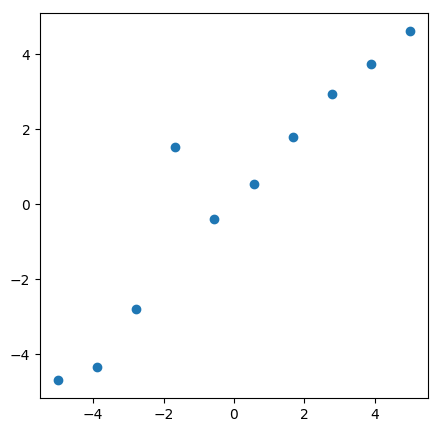

In [32]:
xs = collect(linspace(-5., 5., 10))
ys = xs + randn(10) * 0.2
ys[4] = -ys[4]
plt[:figure](figsize=(5, 5))
plt[:scatter](xs, ys);

We run likelihood-weighting 36 times, where each run uses 10,000 samples from the prior. This might take a several seconds:

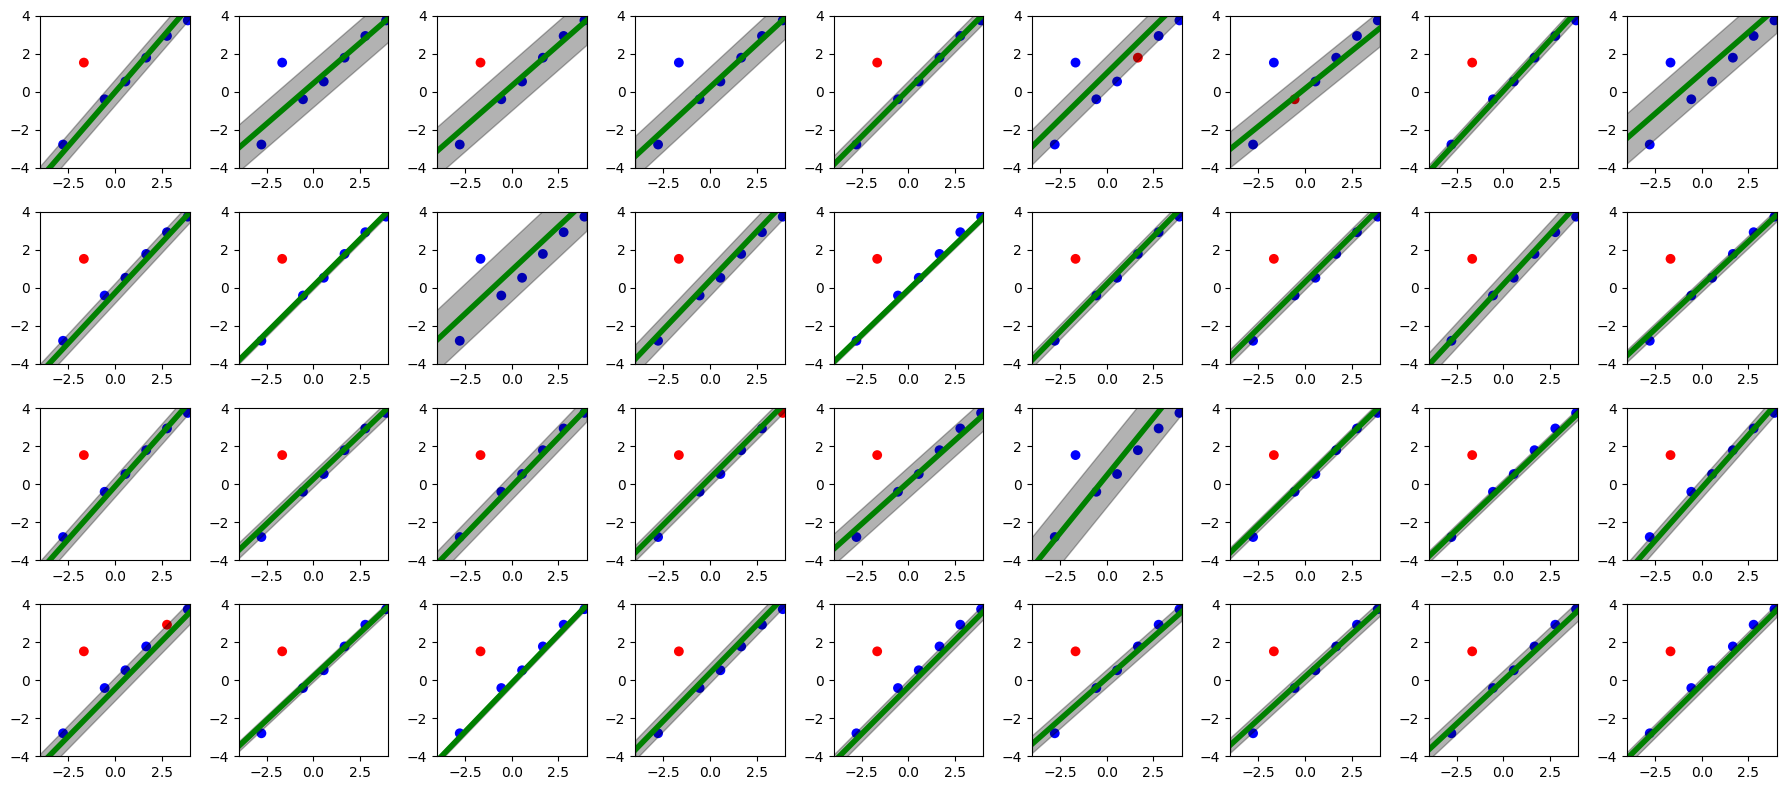

In [33]:
traces = []
for replicate=1:36
    trace = Trace()
    num_samples = 10000
    push!(traces, linear_regression_likelihood_weighting(num_samples, xs, ys))
end

plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_linear_regression_outliers_trace(trace, xs, ax, xlim, ylim)
end
plt[:tight_layout]()

Most of the samples should show the outlier in red.

That inference algorithm was a little slow, because we had to wait for it. Let's see what happens when we use a less accurate but faster version, that only uses 100 samples from the prior:

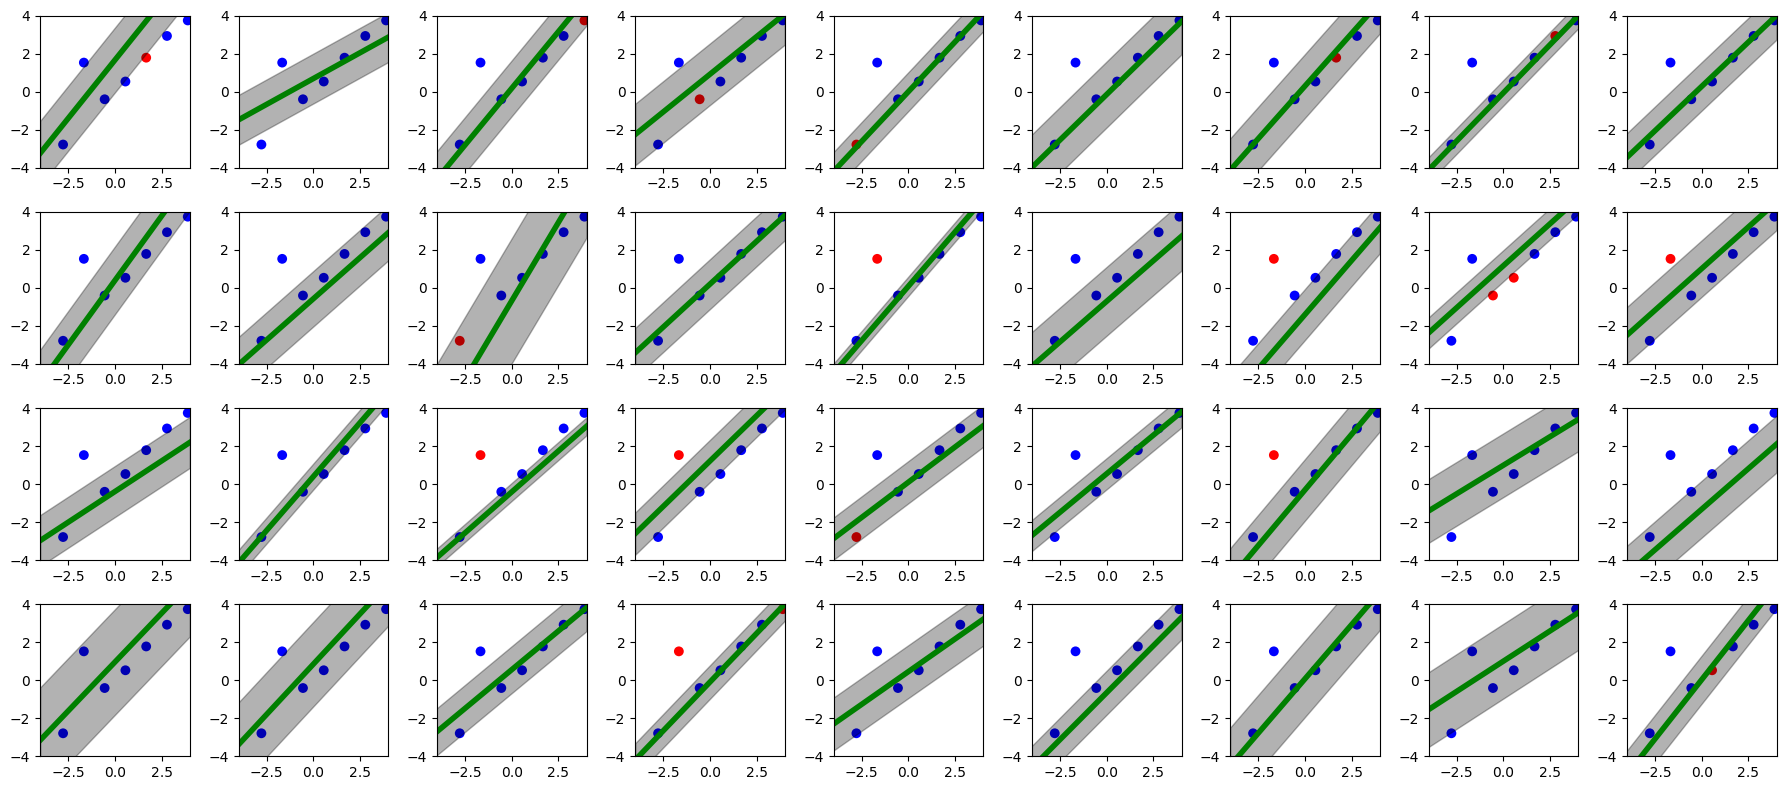

In [34]:
traces = []
for replicate=1:36
    trace = Trace()
    num_samples = 100
    push!(traces, linear_regression_likelihood_weighting(num_samples, xs, ys))
end

plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_linear_regression_outliers_trace(trace, xs, ax, xlim, ylim)
end
plt[:tight_layout]()

## Problem 2.1

The distribution on traces produced by the inference algorithm above seems to be mostly 'unimodal' because most of the probability mass is concentrated within one contiguous region in the set of traces, or centered at one trace.

Create a new dataset that results in a bimodal posterior distribution on the slope and intercept. Run the likelihoog-weighting inference algorithm on that dataset and visualize the traces to see the bimodality.

NOTE: Do not simply create a bimodal prior. The prior on slope and intercept must be unimodal.

In [35]:
## ANSWER HERE